In [59]:
import os 
from pathlib import Path 
from planttraits.config import TRAIN_IMAGES_FOLDER
from planttraits.utils import TARGET_COLUMN_NAMES, STD_COLUMN_NAMES
from planttraits.datasets.plant_traits_dataset import PlantTraitsDataset
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import pandas as pd 
from torchvision import transforms
import torchvision
import pytorch_lightning as pl
from torchmetrics.functional import r2_score, mean_squared_error
import torch
import torch.nn as nn
import warnings
import numpy as np

# Suppress all warnings
warnings.filterwarnings("ignore")

## Możliwe rozwiązania
1. Autoenkoder wielomodalny + FFN
2. Dwa oddzielne modele, potem fuzja do jednego
3. Feed Forward Network
4. XGBRegressor
5. Klasteryzacja

Możliwości dla 3 i 4:
- zastosowanie tylko wartości numerycznych
- przy pomocy gotowego modelu wygenerowanie embeddingów dla zdjęć, które są potem spłaszczane i dołączane do danych numerycznych

dla 2: [Dla tych co rozumieja Keras](https://www.kaggle.com/code/potcoveanuflorin/planttraits-efficientnet-image-tabular), lub z zeszłej edycji [rozwiązanie](https://www.kaggle.com/competitions/planttraits2023/discussion/425729), z obecnej edycji również proste [rozwiązanie](https://www.kaggle.com/code/nick33990/planttrait-convformer-mlp)

#### Co warto dodatkowo rozważyć
1. Klasyfikacja -> wybieramy wartości cech dla klasy przewidzianego gatunku, można też na podstawie znormalizowanych logitów obliczyć średnią ważoną i tak przewidzieć cechę

2. [X[*]_mean] jest wektorem przewidzianych cech - wykorzystanie odległości cosinusowej jako (dodatkowej) miary błędu

3. Walidacja k-krzyżowa, czyli wytrenowanie np. 5 takich samych modeli, ale każdy na innym podzbiorze danych, a końcowo uśrednić (średnia ważona?) przewidywania modeli. 

4. Porównać między sobą modele z różnymi bazowymi sieciami

5. Wykorzystać różne miary błędu, w tym R2, można też regularyzacje dodać (pewnie tu lepsze będzie L1)

### Przygotowanie danych

In [60]:
train_dataset = PlantTraitsDataset(is_train=True)

In [63]:
cols = train_dataset.data.columns
feat_cols = cols[~cols.isin([*TARGET_COLUMN_NAMES, *STD_COLUMN_NAMES])]
transf_cols = [*feat_cols, *STD_COLUMN_NAMES, TARGET_COLUMN_NAMES[0]]
len(cols), len(feat_cols), len(transf_cols)

(175, 163, 170)

Tu dla prostoty wszystkie wartości były tylko ustandaryzowane

In [64]:
scaler = StandardScaler()
target_scaler = RobustScaler()
targets = target_scaler.fit_transform(train_dataset.data[TARGET_COLUMN_NAMES[1:]].apply(np.log))
data = scaler.fit_transform(train_dataset.data[transf_cols])
data = pd.DataFrame(data, index=train_dataset.indexes, columns=[transf_cols])
data[TARGET_COLUMN_NAMES[1:]] = targets
data[STD_COLUMN_NAMES] = data[STD_COLUMN_NAMES].fillna(0)
train_dataset.set_data(data)

Dla X4_mean nie można logarytmicznego przekształcenia zastosować bo zostają wartości nan

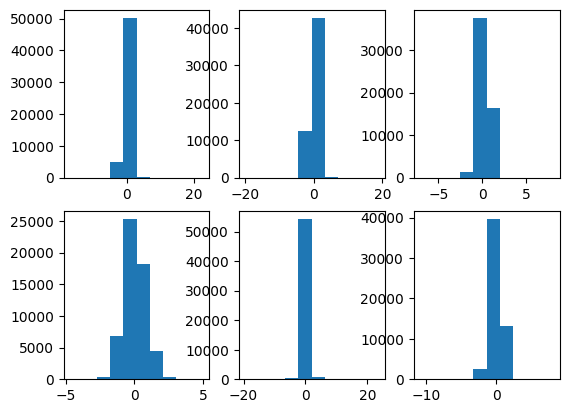

In [65]:
for i in range(len(TARGET_COLUMN_NAMES)):
    plt.subplot(2, 3, i + 1)
    plt.hist(train_dataset.data[TARGET_COLUMN_NAMES[i]])

(array([2.3700e+02, 8.5110e+03, 2.4927e+04, 1.5138e+04, 4.2210e+03,
        1.3170e+03, 7.2600e+02, 3.0500e+02, 8.9000e+01, 1.8000e+01]),
 array([-0.88921171, -0.58541046, -0.2816092 ,  0.02219205,  0.3259933 ,
         0.62979455,  0.9335958 ,  1.23739706,  1.54119831,  1.84499956,
         2.14880081]),
 <BarContainer object of 10 artists>)

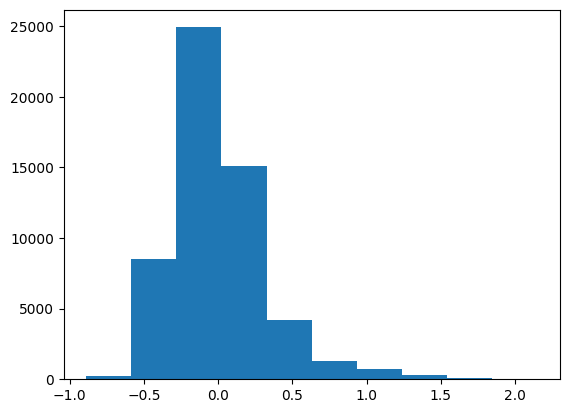

In [66]:
plt.hist(train_dataset.data.mean(axis=1))

In [67]:
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])

In [68]:
train_loader = DataLoader(train_dataset, batch_size=64)
val_loader = DataLoader(val_dataset, batch_size=64)

In [69]:
sample = next(iter(train_loader))

Dla modeli przetrenowanych najlepiej, by zakres wartości dla zdjęć był między 0 a 1. Można też w specyfikacji modelu podpatrzeć, np. [EfficientNet_B2](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet_B2_Weights), jakie transformacje były aplikowane do zdjęć, bo na pewno rozmiar wejściowy musi się zgadzać. 

In [70]:
train_transforms = transforms.Compose(
    [transforms.Resize(size=(232, 232)), 
     transforms.ConvertImageDtype(torch.float), 
     transforms.CenterCrop(size=224), 
     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [71]:
train_transforms(sample[0])

tensor([[[[0.3825, 0.3860, 0.3889,  ..., 0.2547, 0.2774, 0.3801],
          [0.4088, 0.3768, 0.4002,  ..., 0.2257, 0.2304, 0.2771],
          [0.4143, 0.4038, 0.3687,  ..., 0.2799, 0.2620, 0.2791],
          ...,
          [0.5248, 0.5476, 0.4756,  ..., 0.7219, 0.7924, 0.8185],
          [0.1683, 0.4285, 0.5346,  ..., 0.8153, 0.8517, 0.8931],
          [0.1555, 0.3584, 0.5240,  ..., 0.7827, 0.8215, 0.8779]],

         [[0.5083, 0.5252, 0.5323,  ..., 0.3810, 0.3998, 0.4970],
          [0.5385, 0.5234, 0.5521,  ..., 0.3502, 0.3506, 0.3929],
          [0.5367, 0.5489, 0.5249,  ..., 0.4018, 0.3803, 0.3930],
          ...,
          [0.5883, 0.5828, 0.4870,  ..., 0.7409, 0.8052, 0.8281],
          [0.2244, 0.4545, 0.5389,  ..., 0.7137, 0.7443, 0.7823],
          [0.2052, 0.3779, 0.5198,  ..., 0.6550, 0.6862, 0.7381]],

         [[0.2863, 0.3334, 0.3696,  ..., 0.1939, 0.2303, 0.3590],
          [0.3403, 0.3231, 0.3532,  ..., 0.1889, 0.2129, 0.2851],
          [0.3690, 0.3447, 0.2956,  ..., 0

In [72]:
efficientnet_b2 = torchvision.models.efficientnet_b2()

Zamrożenie wag!

In [73]:
for param in efficientnet_b2.parameters():
    param.requires_grad_(False)

In [74]:
for mod in efficientnet_b2.named_modules():
    print(mod)

('', EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAc

Funkcją ewaluującą (dla tego challenge) jest $R^2$, który obliczany jest wedle wzoru $$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$ gdzie $SS_{res} = \sum{(\hat{y} - y) ^ 2}$ i $SS_{tot} = \sum{(\overline{y} - y) ^ 2}$ (proporcjonalne do estymacji wariancji) dla $\overline{y} = \frac{\sum{y}}{n}$. Jest normalnie w zakresie $(0, 1)$, gdzie *1* oznacza, że estymator jest dokładnie dopasowany (co może oznaczać jednak wysoką wariancję modelu) oraz $0$, gdy estymator zwraca jako predykcję $\overline{y}$ (wtedy model ma wysoki bias, nie jest wystarczająco skomplikowany). Możecie na podstawie krzywych uczenia i $R^{2}$ dopasowywać ilość i wielkość warstw w waszym modelu.

Jeśli to ma być funkcja straty, to trzeba ją 'odwrócić', czyli obliczać $1 - R^{2}$

In [75]:
class PTNN(pl.LightningModule):
    def __init__(self, 
                 n_feat, 
                 backbone_net, 
                 criteria,
                 lr=1e-3, 
                 optim_alg=torch.optim.Adam):
        super().__init__()
        self.lr = lr
        self.optim_alg = optim_alg
        self.n_feat = n_feat
        self.criteria = criteria
        self.climate_encoder = nn.Sequential(
            nn.Linear(n_feat, 256), nn.LayerNorm(256), nn.ReLU(),
            nn.Linear(256, 512), nn.LayerNorm(512), nn.ReLU(),
            nn.Linear(512, 1000), nn.LayerNorm(1000), nn.ReLU(),
            nn.Linear(1000, 512), nn.LayerNorm(512), nn.ReLU(),
            nn.Linear(512, 256), nn.LayerNorm(256)
        )
        
        self.img_encoder = nn.Sequential(
            backbone_net, nn.Linear(1000, 512), nn.LayerNorm(512), nn.ReLU(),
            nn.Linear(512, 256), nn.LayerNorm(256)
        )

        self.prediction_head = nn.Sequential(
            nn.Linear(512, 1024), nn.LayerNorm(1024), nn.ReLU(),
            nn.Linear(1024, 512), nn.LayerNorm(512), nn.ReLU(),
            nn.Linear(512, 256), nn.LayerNorm(256), nn.ReLU(),
            nn.Linear(256, 6) 
        )

    def training_step(self, batch, batch_idx):
        predictions, mean_row = self.run_forward(batch)
        loss = self.criteria(predictions, mean_row)
        self.log('train_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        self.log('train_score', r2_score(predictions, mean_row), prog_bar=True, sync_dist=True, on_epoch=True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        predictions, mean_row = self.run_forward(batch)
        loss = self.criteria(predictions, mean_row)
        self.log('val_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        self.log('val_score', r2_score(predictions, mean_row), prog_bar=True, sync_dist=True, on_epoch=True)
        return {'val_loss': loss}
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        predictions, _ = self.run_forward(batch)
        return predictions
    
    def forward(self, img, row):
        climate_features = self.climate_encoder(torch.concat([row], dim=1))
        image_features = self.img_encoder(img)
        features = torch.concat([climate_features, image_features], dim=1)
        pred = self.prediction_head(features)
        return pred  
    
    def run_forward(self, batch):
        img, row, *_, mean_row = batch
        row = row[:, :self.n_feat]
        img = train_transforms(img)
        return self.forward(img, row), mean_row

    def configure_optimizers(self):
        # W przypadku skomplikowanych modeli można dodać więcej optymizatorów
        optimizer = self.optim_alg(self.parameters(), lr=self.lr)
        return optimizer


In [76]:
kwargs = {
    "n_feat": len(feat_cols),
    "backbone_net": efficientnet_b2,
    "criteria": mean_squared_error
}

In [77]:
ptnn = PTNN(**kwargs)

In [78]:
pred, true = ptnn.run_forward(sample)

(array([[ 3.,  9., 20., 16., 14.,  2.,  0.,  0.,  0.,  0.],
        [ 2.,  3., 13., 18., 17.,  7.,  4.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  1., 10., 19., 22.,  7.,  3.,  1.],
        [ 0.,  0.,  0.,  0.,  2.,  9., 26., 14.,  9.,  4.],
        [ 0.,  0.,  7., 15., 24., 10.,  7.,  1.,  0.,  0.],
        [ 0.,  5.,  8., 15., 20., 13.,  2.,  1.,  0.,  0.]]),
 array([-0.52653849, -0.36781695, -0.2090954 , -0.05037386,  0.10834768,
         0.26706922,  0.42579076,  0.58451229,  0.74323386,  0.90195537,
         1.06067693]),
 <a list of 6 BarContainer objects>)

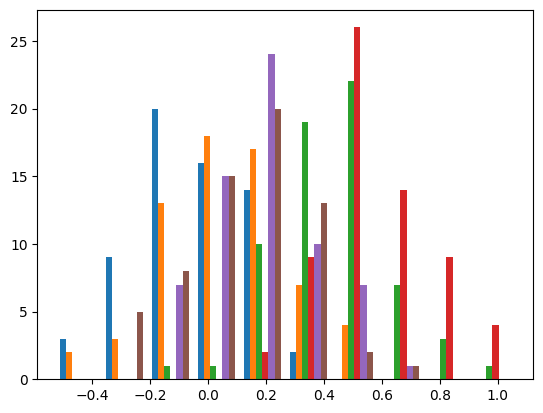

In [79]:
plt.hist(pred.detach().numpy())

(array([[ 2.,  4., 13., 12., 11., 11.,  5.,  2.,  2.,  2.],
        [ 4.,  2., 11.,  8., 10., 12.,  9.,  5.,  3.,  0.],
        [ 0.,  1.,  9., 17., 17.,  9.,  4.,  7.,  0.,  0.],
        [ 2.,  3.,  9., 13., 17.,  8.,  7.,  2.,  2.,  1.],
        [ 2.,  8.,  7., 12., 14., 10.,  6.,  4.,  1.,  0.],
        [ 2.,  0., 10., 19.,  8., 11., 11.,  1.,  2.,  0.]]),
 array([-1.85591161, -1.43431997, -1.01272845, -0.59113687, -0.16954529,
         0.25204629,  0.67363787,  1.09522939,  1.51682103,  1.93841267,
         2.36000419]),
 <a list of 6 BarContainer objects>)

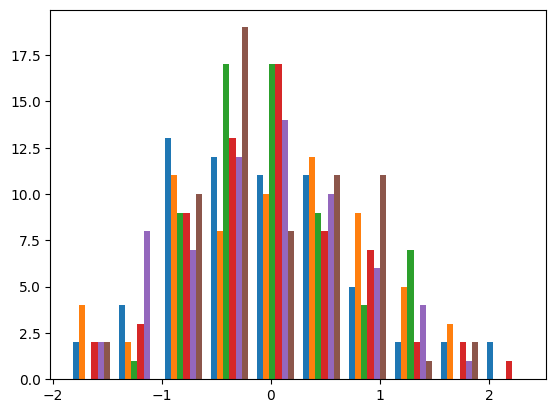

In [80]:
plt.hist(true.detach().numpy())

In [81]:
mean_squared_error(pred, true)

tensor(0.7272, grad_fn=<DivBackward0>)

In [82]:
true[:, 0]

tensor([ 0.2341,  0.1310,  1.6014, -0.4037, -0.5215, -1.2230,  2.3600,  0.4572,
         1.4409,  0.5177,  0.8487, -0.4277, -0.7783, -0.2682,  2.0952,  0.5825,
         0.1443,  0.5772,  0.2120, -0.8622, -1.0541, -0.2085, -0.5468,  0.0850,
         0.3664, -0.8396,  0.1930, -1.4638, -0.5306,  0.3418,  0.8271, -0.4730,
        -0.7263,  0.5902, -0.3508,  0.3353, -0.9921,  0.8377,  0.2318, -1.0508,
        -1.1817,  0.5572, -0.7595, -0.9246, -0.3684,  0.2088,  0.2263, -0.1996,
        -1.4947,  0.2258, -0.7765, -0.7596,  1.6431,  0.1148,  0.3434,  0.9478,
        -0.7263,  0.3201, -0.9994, -0.9161, -1.0053,  1.1972,  1.0107, -0.2447])

In [83]:
checkpoint_dir = Path(f'../models')
os.makedirs(checkpoint_dir, exist_ok=True)
model_name = 'ptnn-effnetb2'
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir / model_name, filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True) 
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)
max_epochs = 20

"The R2 can result in large negative values. To prevent that we will only consider R2 values > 0." - jak sobie z tym poradzić?

Dodatkowo, jeśli tutaj w funkcji straty wyjdzie wam nan to prawdopodobnie jest jakaś wartość nan w danych

In [84]:
trainer = pl.Trainer(max_epochs=max_epochs, 
                     default_root_dir=checkpoint_dir / model_name, 
                     fast_dev_run=True, # True dla szybkiego przebiegu sprawdzającego, czy wszystkie warstwy są poprawne itd.
                     callbacks=[checkpoint_callback]
                     )

trainer.fit(ptnn, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | climate_encoder | Sequential | 1.3 M  | train
1 | img_encoder     | Sequential | 9.8 M  | train
2 | prediction_head | Sequential | 1.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
9.1 M     Non-trainable params
12.3 M    Total params
49.110    Total estimated model params size (MB)
505       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


In [85]:
pred, true = ptnn.run_forward(sample)

In [86]:
trainer = pl.Trainer(max_epochs=max_epochs, default_root_dir=checkpoint_dir / model_name, fast_dev_run=False)
model = PTNN.load_from_checkpoint(r'C:\Users\julia\VSCode\PlantTraits2024\models\ptnn-effnetb2\epoch=13-val_loss=0.67-train_loss=0.63.ckpt',
                                  **kwargs)
_ = model.eval()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [90]:
test_dataset = PlantTraitsDataset(is_train=False)
test_dataset.data[['X4_mean', *STD_COLUMN_NAMES]] = 0
data = scaler.transform(test_dataset.data[transf_cols])
test_dataset.data = pd.DataFrame(data, index=test_dataset.indexes, columns=[transf_cols])

In [91]:
test_loader = DataLoader(test_dataset, batch_size=64)

In [92]:
preds = trainer.predict(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [93]:
torch.concat(preds).shape

torch.Size([6545, 6])

In [94]:
test_dataset.data[TARGET_COLUMN_NAMES] = torch.concat(preds).numpy()

In [95]:
test_dataset.data

,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,SOIL_bdod_30.60cm_mean_0.01_deg,...,X18_sd,X26_sd,X50_sd,X3112_sd,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean
1040495,-0.855775,1.544619,-0.079489,-1.145527,-0.522180,-0.840492,-2.095428,-2.073568,-2.382196,-2.505118,...,-0.018153,-0.013243,-0.470843,-0.10796,0.037657,-0.711146,-0.107371,-0.249226,0.410620,-0.623065
2369917,-0.492187,-0.731925,-0.807434,-1.198699,0.845956,0.444280,0.744238,0.977825,0.861629,0.698061,...,-0.018153,-0.013243,-0.470843,-0.10796,-0.416357,0.264573,-0.164316,-0.187018,-0.270698,-0.155299
4292100,-0.853296,-0.884779,-0.720161,-0.468310,0.642292,1.051957,0.914619,-0.415202,0.674485,-0.070702,...,-0.018153,-0.013243,-0.470843,-0.10796,-0.437155,-0.127022,-0.296389,-0.165471,0.223515,-0.494222
4987598,-0.988824,-0.233977,-0.496567,-0.621044,0.475902,-0.008435,-0.789182,-0.017194,-0.760284,-0.391020,...,-0.018153,-0.013243,-0.470843,-0.10796,-0.548483,0.479328,-0.363393,-0.400112,-0.420294,-0.180951
5608104,-1.290388,1.613367,0.088233,-1.028363,-0.176314,-0.296194,-1.811462,-1.741895,-1.883146,-1.736355,...,-0.018153,-0.013243,-0.470843,-0.10796,0.099640,-1.253363,-0.242799,-0.375463,0.398699,-0.864127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203058111,0.198399,0.221261,-0.361207,-0.997136,-0.468167,-0.722240,-0.618802,-0.282533,-0.635521,-0.391020,...,-0.018153,-0.013243,-0.470843,-0.10796,0.489000,-1.203310,0.189676,-0.103155,0.591163,-0.607972
203059691,1.222397,1.065181,1.081715,0.186324,-1.493906,-1.205005,-0.618802,-0.547871,-0.385996,-0.583211,...,-0.018153,-0.013243,-0.470843,-0.10796,0.183633,-0.047572,0.885360,0.866706,0.041897,0.908182
203060031,-0.222955,0.157715,-0.660990,-1.305533,1.104873,1.056471,0.744238,1.574837,1.547823,1.594951,...,-0.018153,-0.013243,-0.470843,-0.10796,-0.413260,0.445242,-0.003916,-0.130176,-0.492784,0.078069
203061083,-0.898688,-0.585170,-0.621717,-0.762754,1.188446,0.655546,-0.334835,0.845156,0.424960,0.633997,...,-0.018153,-0.013243,-0.470843,-0.10796,-0.339028,0.216394,-0.096417,-0.159373,-0.264100,-0.102780


Trzeba pamiętać, że na początku robiliśmy transformacje na zmiennych zależnych, więc z powrotem trzeba je przekształcić do prawidłowej postaci

In [96]:
denorm_pred = scaler.inverse_transform(test_dataset.data[transf_cols])[:, -1]

In [97]:
test_preds = np.c_[denorm_pred, target_scaler.inverse_transform(np.exp(test_dataset.data[TARGET_COLUMN_NAMES[1:]]))]

In [98]:
submission = pd.DataFrame(test_preds, index=test_dataset.data.index, columns=TARGET_COLUMN_NAMES).reset_index().rename({'index': 'id'}, axis=1)

In [99]:
submission.to_csv(TRAIN_IMAGES_FOLDER.parent / 'submission.csv', index=False)